In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results as a confusion-matrix

print(tf.__version__)

2.16.1


In [64]:
import os

imagepaths = []
data_dir = 'C:/Users/vaish/OneDrive/Desktop/project/project/leapGestRecog/'

for root, dirs, files in os.walk(data_dir, topdown=False): 
    for name in files:
        path = os.path.join(root, name)
        if path.endswith("png"):
            imagepaths.append(path)

print(len(imagepaths))


20000


In [71]:
X = [] # Image data
y = [] # Labels

# Loops through imagepaths to load images and labels into arrays
for path in imagepaths:
    img = cv2.imread(path) # Reads image and returns np.array
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
    img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
    X.append(img)
  
  # Processing label in image path
    category = path.split("/")[8]
    #print("Category:", category)  
    label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
    y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0]) # Debugging

Images loaded:  20000
Labels loaded:  20000
0 C:/Users/vaish/OneDrive/Desktop/project/project/leapGestRecog/00\01_palm\frame_00_01_0001.png


In [73]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

In [75]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


In [76]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

C:\Users\vaish\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [77]:
# Configures the model for training
model.compile(optimizer='adam', # Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.
              loss='sparse_categorical_crossentropy', # Loss function, which tells us how bad our predictions are.
              metrics=['accuracy']) # List of metrics to be evaluated by the model during training and testing.

In [78]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Epoch 1/5
219/219 - 265s - 1s/step - accuracy: 0.9238 - loss: 0.6169 - val_accuracy: 0.9900 - val_loss: 0.0314
Epoch 2/5
219/219 - 261s - 1s/step - accuracy: 0.9894 - loss: 0.0311 - val_accuracy: 0.9915 - val_loss: 0.0187
Epoch 3/5
219/219 - 261s - 1s/step - accuracy: 0.9917 - loss: 0.0193 - val_accuracy: 0.9918 - val_loss: 0.0127
Epoch 4/5
219/219 - 233s - 1s/step - accuracy: 0.9918 - loss: 0.0155 - val_accuracy: 0.9912 - val_loss: 0.0145
Epoch 5/5
219/219 - 235s - 1s/step - accuracy: 0.9934 - loss: 0.0138 - val_accuracy: 0.9917 - val_loss: 0.0146


In [82]:
# Save entire model to a HDF5 file
model.save('mp_hand_gesture.keras')

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
mpHands = mp.solutions.hands
hands = mpHands.Hands(max_num_hands=1, min_detection_confidence=0.7)
mpDraw = mp.solutions.drawing_utils

In [3]:
model = load_model('handrecognition_model.keras')

C:\Users\vaish\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [8]:
f=open("gesture.names",'r')
class_names=f.read().split("\n")
f.close()
print(class_names)

['palm', 'I', 'fist', 'fist_moved', 'thumb', 'index', 'ok', 'palm_moved', 'c', 'down', '']


In [11]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import load_model

# Initialize MediaPipe Hands
mpHands = mp.solutions.hands
hands = mpHands.Hands()

# Initialize MediaPipe Drawing Utilities
mpDraw = mp.solutions.drawing_utils

# Initialize the webcam
cap = cv2.VideoCapture(0)
model = load_model('handrecognition_model.keras')

while True:
    # Read each frame from the webcam
    ret, frame = cap.read()

    if not ret:
        break

    # Flip the frame vertically
    frame = cv2.flip(frame, 1)
    framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Get hand landmark prediction
    result = hands.process(framergb)

    # print(result)
    
    className = ''

    # post process the result
    if result.multi_hand_landmarks:
        landmarks = []
        for handslms in result.multi_hand_landmarks:
            for lm in handslms.landmark:
                # print(id, lm)
                height, width, _ = frame.shape
                lmx = int(lm.x * width)
                lmy = int(lm.y * height)

                landmarks.append([lmx, lmy])

            # Drawing landmarks on frames
            mpDraw.draw_landmarks(frame, handslms, mpHands.HAND_CONNECTIONS)

            # Convert landmarks to image
            landmarks_image = np.zeros((height, width))
            for landmark in landmarks:
                x, y = landmark
                x = min(max(x, 0), width - 1)  # Ensure x is within image bounds
                y = min(max(y, 0), height - 1)  # Ensure y is within image bounds
                landmarks_image[y, x] = 1  # Set pixel intensity to 1 to represent landmark presence
            
            # Resize landmarks_image to match model input shape
            landmarks_image_resized = cv2.resize(landmarks_image, (320, 120))
            landmarks_image_resized = np.expand_dims(landmarks_image_resized, axis=-1)

            # Predict gesture
            prediction = model.predict(np.array([landmarks_image_resized]))
            print(prediction)
            classID = np.argmax(prediction)
            print(classID)
            className = class_names[classID]
            print(className)

    # show the prediction on the frame
    cv2.putText(frame, className, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                   1, (0,0,255), 2, cv2.LINE_AA)

    # Show the final output
    cv2.imshow("Output", frame) 

    if cv2.waitKey(1) == ord('q'):
        break

# release the webcam and destroy all active windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[[2.8835135e-03 1.0969396e-06 1.7273691e-05 2.8659229e-04 1.4777905e-05
  6.8806858e-06 2.1108819e-05 5.5287943e-05 9.9647659e-01 2.3693110e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[2.90204096e-03 1.14092563e-06 1.81731175e-05 2.71128170e-04
  1.50193355e-05 7.20760681e-06 1.96475612e-05 5.33692109e-05
  9.96483684e-01 2.28680219e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[2.8765672e-03 1.0877910e-06 1.7580016e-05 2.7367231e-04 1.4230528e-05
  6.6846337e-06 2.0267000e-05 5.5273445e-05 9.9650794e-01 2.2659237e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[2.9895178e-03 1.1439844e-06 1.7716678e-05 2.9024447e-04 1.4406129e-05
  6.9814255e-06 2.1672304e-05 5.6145476e-05 9.9637294e-01 2.2931123e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[2.94668926e-03 1.10649410e-06 1.69239829e-05 2.86225666e-04
  1.40305565e-05 6.92761569e-06 2.12784089e-05 5.57028470e-05
  9.96420145e-01 2.30981881e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/st

In [12]:
import cv2
import mediapipe as mp
import numpy as np
from keras.models import load_model

# Initialize MediaPipe Hands
mpHands = mp.solutions.hands
hands = mpHands.Hands()

# Initialize MediaPipe Drawing Utilities
mpDraw = mp.solutions.drawing_utils

# Load the pre-trained model
model = load_model('handrecognition_model.keras')

# Load class names from file
with open("gesture.names", 'r') as f:
    class_names = [name.strip() for name in f.readlines() if name.strip()]

# Initialize the webcam
cap = cv2.VideoCapture(0)

while True:
    # Read each frame from the webcam
    ret, frame = cap.read()

    if not ret:
        break

    # Flip the frame vertically
    frame = cv2.flip(frame, 1)
    framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Get hand landmark prediction
    result = hands.process(framergb)

    # Initialize className
    className = ''

    # Post-process the result
    if result.multi_hand_landmarks:
        landmarks = []
        for handslms in result.multi_hand_landmarks:
            for lm in handslms.landmark:
                # Get landmark coordinates
                height, width, _ = frame.shape
                lmx = int(lm.x * width)
                lmy = int(lm.y * height)
                landmarks.append([lmx, lmy])

            # Drawing landmarks on frames
            mpDraw.draw_landmarks(frame, handslms, mpHands.HAND_CONNECTIONS)

            # Convert landmarks to image
            landmarks_image = np.zeros((height, width))
            for landmark in landmarks:
                x, y = landmark
                x = min(max(x, 0), width - 1)  # Ensure x is within image bounds
                y = min(max(y, 0), height - 1)  # Ensure y is within image bounds
                landmarks_image[y, x] = 1  # Set pixel intensity to 1 to represent landmark presence
            
            # Resize landmarks_image to match model input shape
            landmarks_image_resized = cv2.resize(landmarks_image, (320, 120))
            landmarks_image_resized = np.expand_dims(landmarks_image_resized, axis=-1)

            # Predict gesture
            prediction = model.predict(np.array([landmarks_image_resized]))
            print(prediction)
            classID = np.argmax(prediction)
            print(classID)
            className = class_names[classID]
            print(className)

    # Show the prediction on the frame
    cv2.putText(frame, className, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2, cv2.LINE_AA)

    # Show the final output
    cv2.imshow("Output", frame) 

    if cv2.waitKey(1) == ord('q'):
        break

# Release the webcam and destroy all active windows
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[[3.1882909e-03 1.1453959e-06 1.7300645e-05 2.8856721e-04 1.5596614e-05
  6.7376782e-06 2.2553606e-05 5.4924898e-05 9.9617529e-01 2.2956243e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[[2.9568279e-03 1.1106147e-06 1.7029977e-05 3.0021192e-04 1.4555570e-05
  7.0503770e-06 2.2072461e-05 5.5638109e-05 9.9638367e-01 2.4179183e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[[3.0773575e-03 1.1194825e-06 1.7737972e-05 3.1285093e-04 1.5089426e-05
  7.2709772e-06 2.3172814e-05 5.7848421e-05 9.9624228e-01 2.4537035e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[[2.9915022e-03 1.1134923e-06 1.7266753e-05 3.0136897e-04 1.4615166e-05
  7.0809115e-06 2.2398288e-05 5.5747441e-05 9.9634898e-01 2.3995651e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[2.9882139e-03 1.0924640e-06 1.6896447e-05 3.0291290e-04 1.4577557e-05
  7.0096130e-06 2.2846203e-05 5.6326859e-05 9.9635303e-01 2.3693088e-04]]
8
c
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[2.9785887e-03 1.093

In [83]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.9933 - loss: 0.0130
Test accuracy: 99.17%


In [84]:
predictions = model.predict(X_test) # Make predictions towards the test set

188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step


In [85]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(5, 5)

In [87]:
# Function to plot images and labels for validation purposes
def validate_9_images(predictions_array, true_label_array, img_array):
    class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
    plt.figure(figsize=(15,5))
  
    for i in range(1, 10):
        prediction = predictions_array[i]
        true_label = true_label_array[i]
        img = img_array[i]
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        # Plot in a good way
        plt.subplot(3,3,i)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img, cmap=plt.cm.binary)

        predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
        
        # Change color of title based on good prediction or not
        if predicted_label == true_label:
            color = 'blue'
        else:
            color = 'red'

        plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
    plt.show()

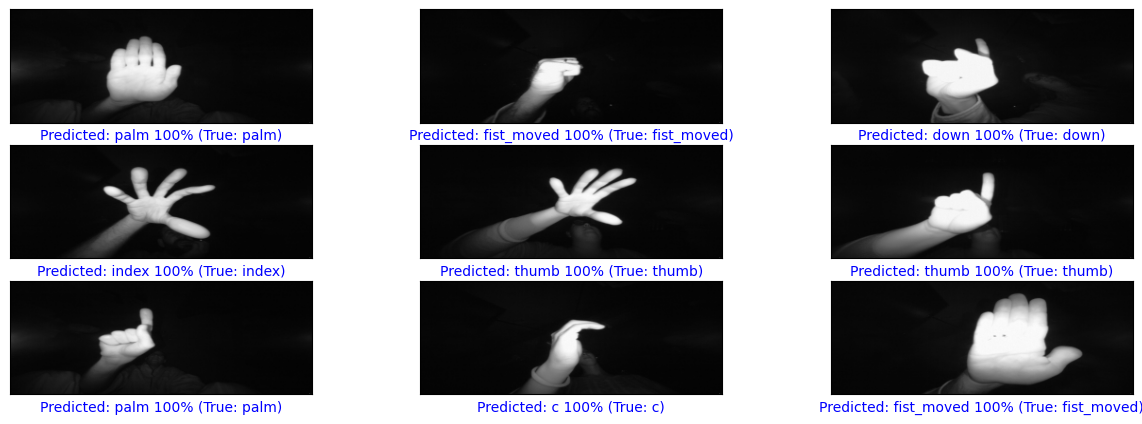

In [88]:
validate_9_images(predictions, y_test, X_test)

In [89]:
y_pred = np.argmax(predictions, axis=1) # Transform predictions into 1-D array with label number

In [90]:
# H = Horizontal
# V = Vertical

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])

,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,565,0,0,0,0,0,0,0,0,0
Actual Palm (H),0,624,0,0,0,0,0,0,0,0
Actual L,0,0,567,0,0,23,0,0,0,0
Actual Fist (H),0,0,0,610,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,628,0,0,0,0,0
Actual Thumbs up,0,0,26,0,0,558,0,0,0,0
Actual Index,0,0,0,0,0,0,618,0,0,0
Actual OK,0,0,0,0,0,0,0,618,0,0
Actual Palm (V),0,0,0,0,0,0,1,0,579,0
Actual C,0,0,0,0,0,0,0,0,0,583
